In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
import scipy.linalg

plt.rc("text", usetex=False)
plt.rc("font", family = "serif",size=14)
plt.rc("figure",figsize=(12,10))
%config InlineBackend.figure_format = 'retina'

Let us begin by defining the Laplacian matrix. We are going to begin with all the rates set equal to 1.0 to recover the results I have generated in previous simulation results. We are also going to perturb every single rate.

In [2]:
labels_f = [0.5, 2.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 2.0, 0.5]

aff = np.log(np.prod(labels_f)/np.prod(labels_r))
print(aff)

0.0


In [3]:
def mtt_k4(labels_f, labels_r):
    # labels_f = k12, k23, k34, k41
    k12, k23, k34, k41 = labels_f[0], labels_f[1], labels_f[2], labels_f[3]
    # labels_r = k21, k32, k43, k14
    k21, k32, k43, k14 = labels_r[0], labels_r[1], labels_r[2], labels_r[3]
    
    rho_1 = (k21*k32*k43) + (k41*k34*k23) + (k21*k32*k41) + (k21*k41*k34)
    rho_2 = (k12*k32*k43) + (k14*k43*k32) + (k21*k32*k41) + (k12*k41*k34)
    rho_3 = (k12*k23*k43) + (k14*k43*k23) + (k12*k41*k23) + (k21*k14*k43)
    rho_4 = (k12*k23*k34) + (k14*k34*k23) + (k32*k21*k14) + (k21*k14*k34)
    
    rho_tot = rho_1 + rho_2 + rho_3 + rho_4
    
    pi = np.array([rho_1/rho_tot, rho_2/rho_tot, rho_3/rho_tot, rho_4/rho_tot],dtype=float)
    
    return pi

In [4]:
def lap_k4(labels_f, labels_r):
    # labels_f = k12, k23, k34, k41
    k12, k23, k34, k41 = labels_f[0], labels_f[1], labels_f[2], labels_f[3]
    # labels_r = k21, k32, k43, k14
    k21, k32, k43, k14 = labels_r[0], labels_r[1], labels_r[2], labels_r[3]
    
    lap = np.array([[-k14-k12, k21, 0, k41], [k12, -k21-k23, k32, 0], [0, k23, -k32-k34, k43], [k14, 0, k34, -k41-k43]],dtype=float)
    
    return lap

In [5]:
lap = lap_k4(labels_f, labels_r)
pi = mtt_k4(labels_f, labels_r)

print("Laplacian:\n", lap)
print("---")
print("Stationary distribution:\n", pi)

Laplacian:
 [[-1.   1.   0.   1. ]
 [ 0.5 -3.   1.   0. ]
 [ 0.   2.  -2.   2. ]
 [ 0.5  0.   1.  -3. ]]
---
Stationary distribution:
 [0.32432432 0.18918919 0.32432432 0.16216216]


In [6]:
signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=500)

In [7]:
def asymmetric_autocorrelation(signal,L,tau,pi,alpha=1,beta=3):
    """
    Numerically calculates the asymmetric autocorrelation functions A^{1,3}(\tau) and A^{3,1}(\tau) for a particular Laplacian matrix. This function works for a linear framework graph of any size.
    
    Parameters
    ----------
    signal : 1D array
        vector of possible values of signal S = (S(1), ..., S(N))
        
    L : NxN array
        column-based Laplacian matrix of linear framework graph with N vertices
    
    tau : 1D array
        range of intervals between values of signal along integration interval
        
    pi : 1D array
         the steady state distribution for a linear framework graph with N vertices
    
    alpha, beta : scalar
        asymmetric exponents applied to signal (default: alpha=1, beta=3)
    
    Returns
    -------
    a_13 : 1D array
        forward autocorrelation function values
    
    a_31 : 1D array
        reverse autocorrelation function values
    
    """
    # initialize forward and reverse autocorrelation function arrays
    a_13 = np.zeros(len(tau))
    a_31 = np.zeros(len(tau))
    
    # define the signal vectors
    s_t = np.array([signal]) # row vector
    s = s_t.T # column vector
    
    # create the diagonal steady state matrix 
    delta_u_star = np.diag(pi)
    
    # vectorize the Laplacian matrix multiplied by each value in the vector tau
    list_result = list(map(lambda i: scipy.linalg.expm(L*i), tau))
    
    # populate arrays with analytical solution to autocorrelation function
    for i in range(len(tau)):
        a_13[i] = ((s_t**beta) @ list_result[i]) @ (delta_u_star @ (s ** alpha))
        a_31[i] = ((s_t**alpha) @ list_result[i]) @ (delta_u_star @ (s ** beta))
        
    return a_13, a_31

In [8]:
def asymmetric_autocorrelation_2(signal, L, tau, pi, alpha=1, beta=3):
    """
    Computes asymmetric autocorrelations A^{1,3}(tau) and A^{3,1}(tau)
    for a linear framework graph with stationary distribution pi.
    
    Parameters
    ----------
    signal : 1D array-like
        Signal values on each node.
    L : 2D array
        Column-based Laplacian.
    tau : 1D array
        Timepoints for evaluation.
    pi : 1D array
        Stationary distribution (sum to 1).
    alpha, beta : int or float
        Powers for asymmetric observable weights.
    
    Returns
    -------
    a13, a31 : 1D arrays
        Forward and reverse autocorrelation values.
    """
    signal = np.array(signal, dtype=np.float64)
    pi = np.array(pi, dtype=np.float64)
    S_alpha = signal ** alpha
    S_beta = signal ** beta

    # Diagonal matrix of steady state
    Delta = np.diag(pi)
    
    # Result arrays
    a13 = np.zeros(len(tau))
    a31 = np.zeros(len(tau))

    for i, t in enumerate(tau):
        expLt = scipy.linalg.expm(L * t)
        a13[i] = S_beta @ expLt @ Delta @ S_alpha
        a31[i] = S_alpha @ expLt @ Delta @ S_beta

    return a13, a31

In [9]:
def autocorrelation_analytical(observable,L,tau_n,alpha=1,beta=3):
    """
    Calculates the analytical solution for forward and reverse higher-order autocorrelation functions for a particular Laplacian matrix
    
    Parameters
    ----------
    observable : 1D array
        possible values of observable (which is a state function on the Markov process)
    L : NxN array
        column-based Laplacian matrix of linear framework graph with N vertices
    tau_n : 1D array
        range of intervals between values of observable taken by system
    alpha : scalar
        exponent applied to observable
    beta : scalar
        exponent applied to transpose of observable
    
    Returns
    -------
    t : 1D array
        forward autocorrelation function values
    t_rev : 1D array
        reverse autocorrelation function values
    
    """
    f = np.array([observable],dtype=np.float128)
    fstar = f.T
    
    # calculate the stationary distribution of the Markov process
    eigvals, eigvecs = scipy.linalg.eig(L)
    pi = np.array([eigvecs[:,np.argmin(np.abs(eigvals))].real/sum(eigvecs[:,np.argmin(np.abs(eigvals))].real)]).T
    
    # initialize forward and reverse autocorrelation function arrays
    t = np.zeros(len(tau_n),dtype=np.float128)
    t_rev = np.zeros(len(tau_n),dtype=np.float128)
    
    list_result = list(map(lambda i: scipy.linalg.expm(L*i), tau_n))
    
    # populate arrays with analytical solution to autocorrelation function
    for i in range(len(tau_n)):
        t[i] = f**alpha @ list_result[i] @(fstar ** beta * pi)
        t_rev[i] = f**beta @ list_result[i] @(fstar ** alpha * pi)
        
    return t, t_rev

In [10]:
a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)

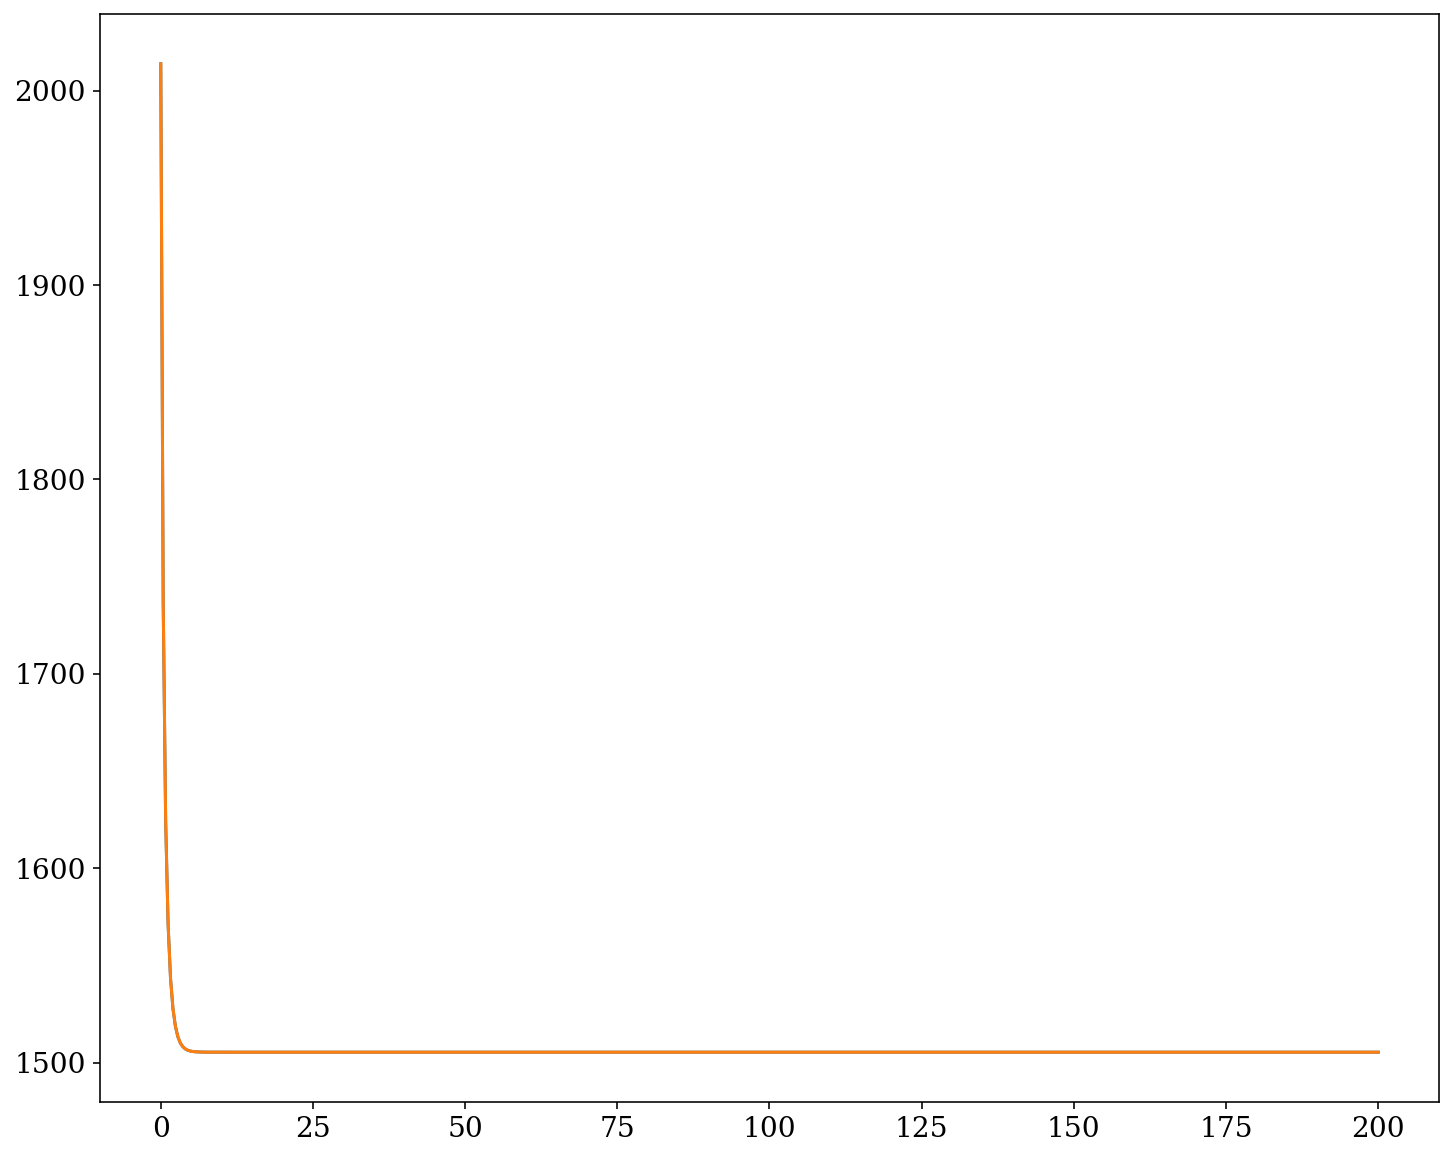

In [11]:
plt.plot(tau,a13)
plt.plot(tau,a31)

In [12]:
area = np.abs(np.trapz(a13)-np.trapz(a31))
print(area)

4.5133674575481563807e-11


In [13]:
# k23
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
edge_idx = 1
perturb_edge = labels_f[edge_idx] # labels_f[1] = k23

for i in tqdm(range(0,N)):
    
    labels_f[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    pi = mtt_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    perturb_edge *= 1.01

np.savez(f"steinberg_edge_{edge_idx}.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [06:07<00:00,  5.44it/s]


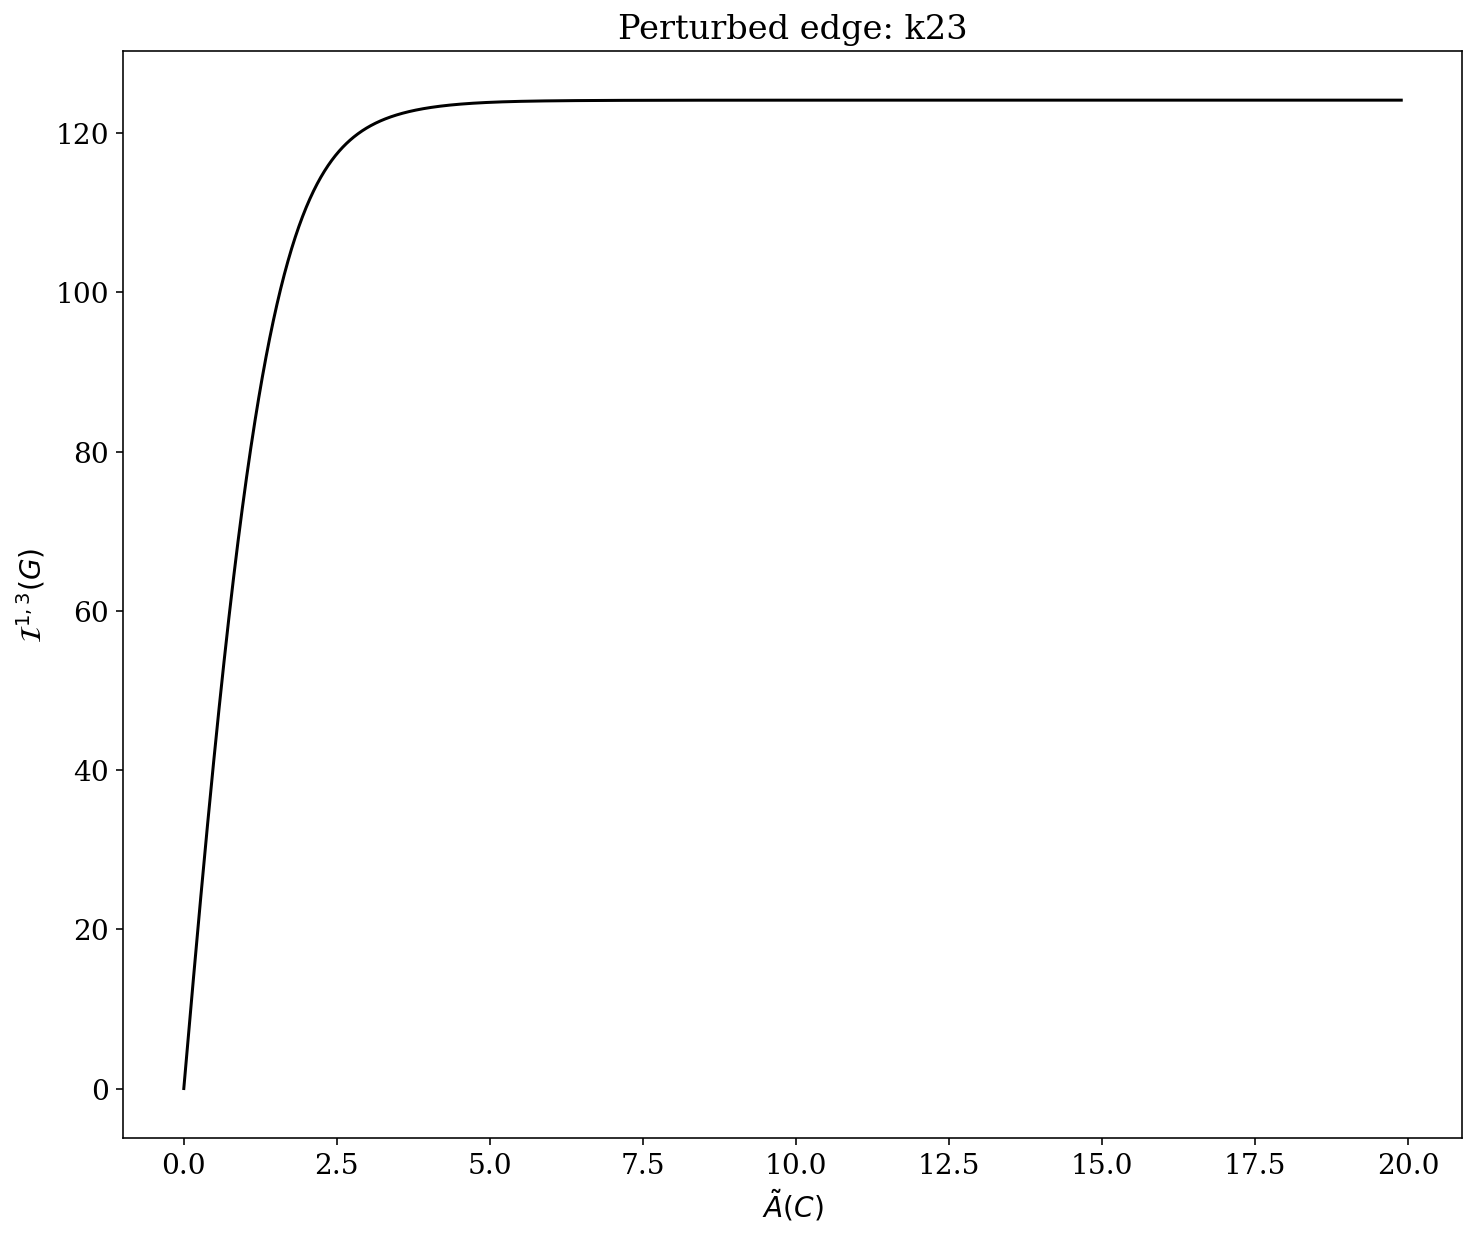

In [14]:
edge_map = {
    0: (1, 2),
    1: (2, 3),
    2: (3, 4),
    3: (4, 1)
}
src, tgt = edge_map[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}.png", dpi=300)
plt.show()

Does it matter which edge label is perturbed?

In [15]:
#k12
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
edge_idx = 0
perturb_edge = labels_f[edge_idx] # labels_f[0] = k12

for i in tqdm(range(0,N)):
    
    labels_f[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    pi = mtt_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    perturb_edge *= 1.01

np.savez(f"steinberg_edge_{edge_idx}.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [06:06<00:00,  5.46it/s]


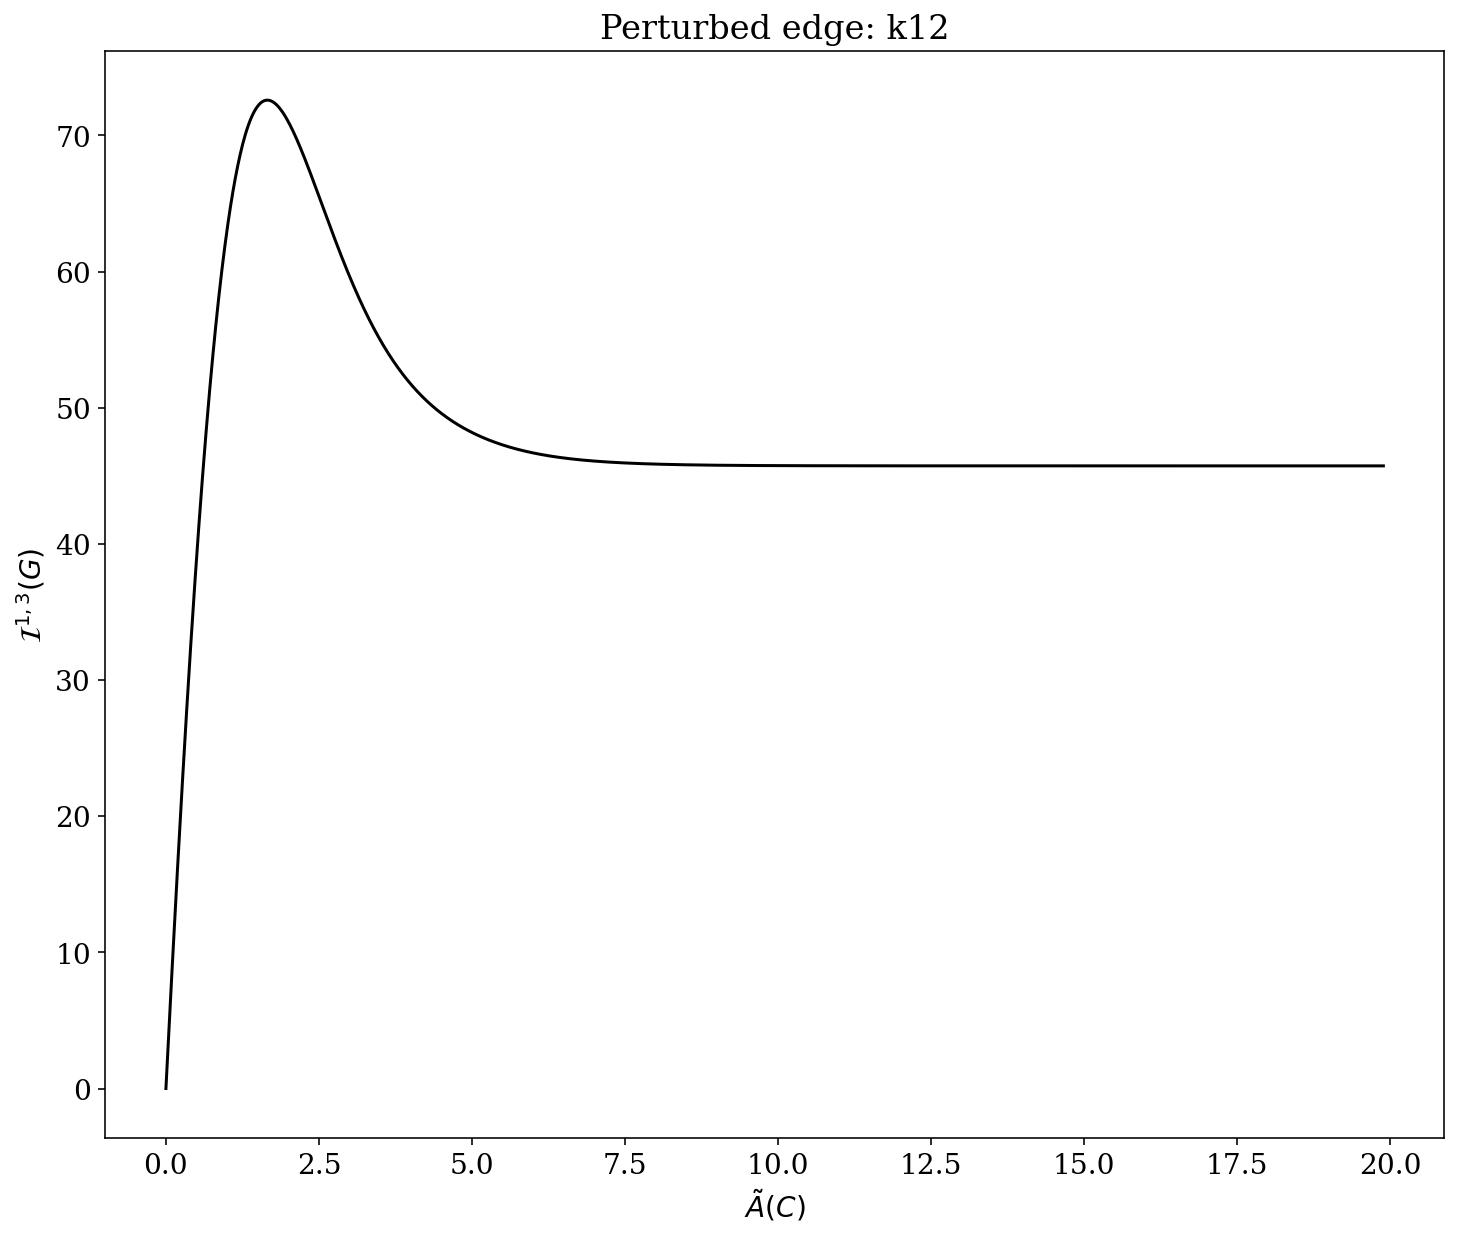

In [16]:
edge_map = {
    0: (1, 2),
    1: (2, 3),
    2: (3, 4),
    3: (4, 1)
}
src, tgt = edge_map[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}.png", dpi=300)
plt.show()

In [17]:
#k34
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
edge_idx = 2
perturb_edge = labels_f[edge_idx] # labels_f[2] = k34

for i in tqdm(range(0,N)):
    
    labels_f[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    pi = mtt_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    perturb_edge *= 1.01
    
np.savez(f"steinberg_edge_{edge_idx}.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [06:04<00:00,  5.48it/s]


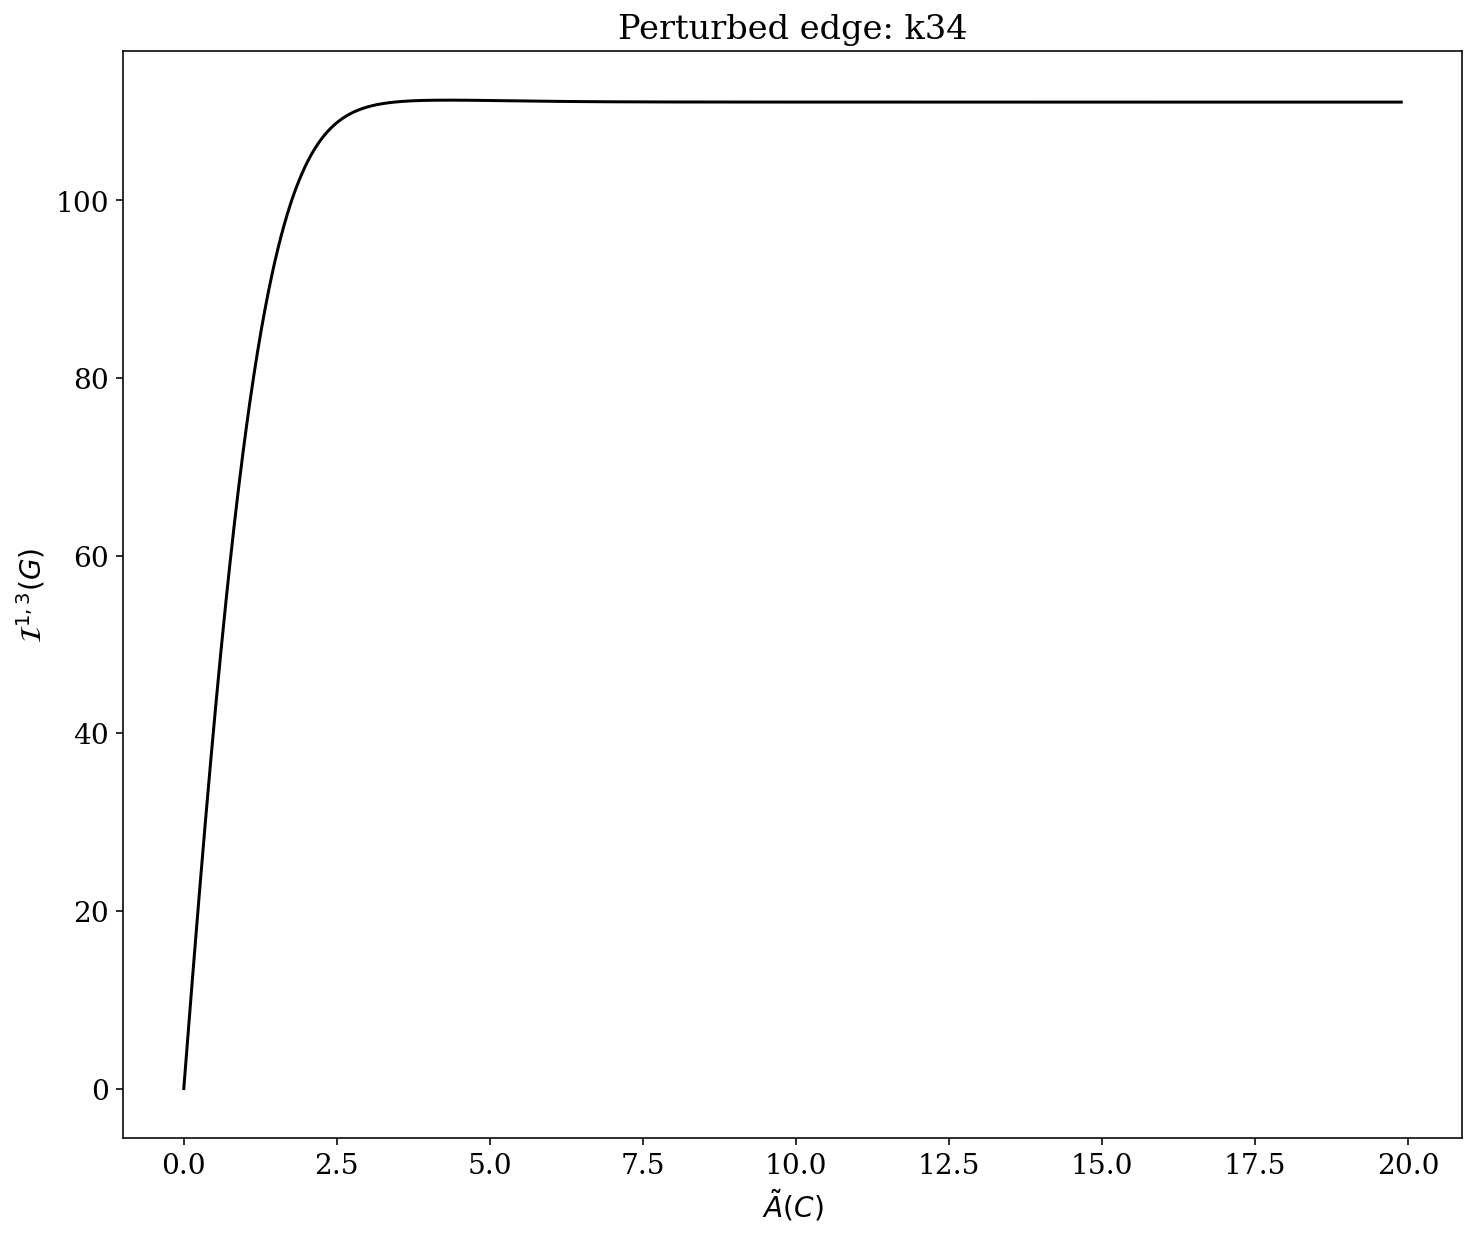

In [18]:
edge_map = {
    0: (1, 2),
    1: (2, 3),
    2: (3, 4),
    3: (4, 1)
}
src, tgt = edge_map[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}.png", dpi=300)
plt.show()

In [19]:
#k41
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
edge_idx = 3
perturb_edge = labels_f[edge_idx] # labels_f[3] = k41

for i in tqdm(range(0,N)):
    
    labels_f[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    pi = mtt_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    perturb_edge *= 1.01
    
np.savez(f"steinberg_edge_{edge_idx}.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [06:02<00:00,  5.52it/s]


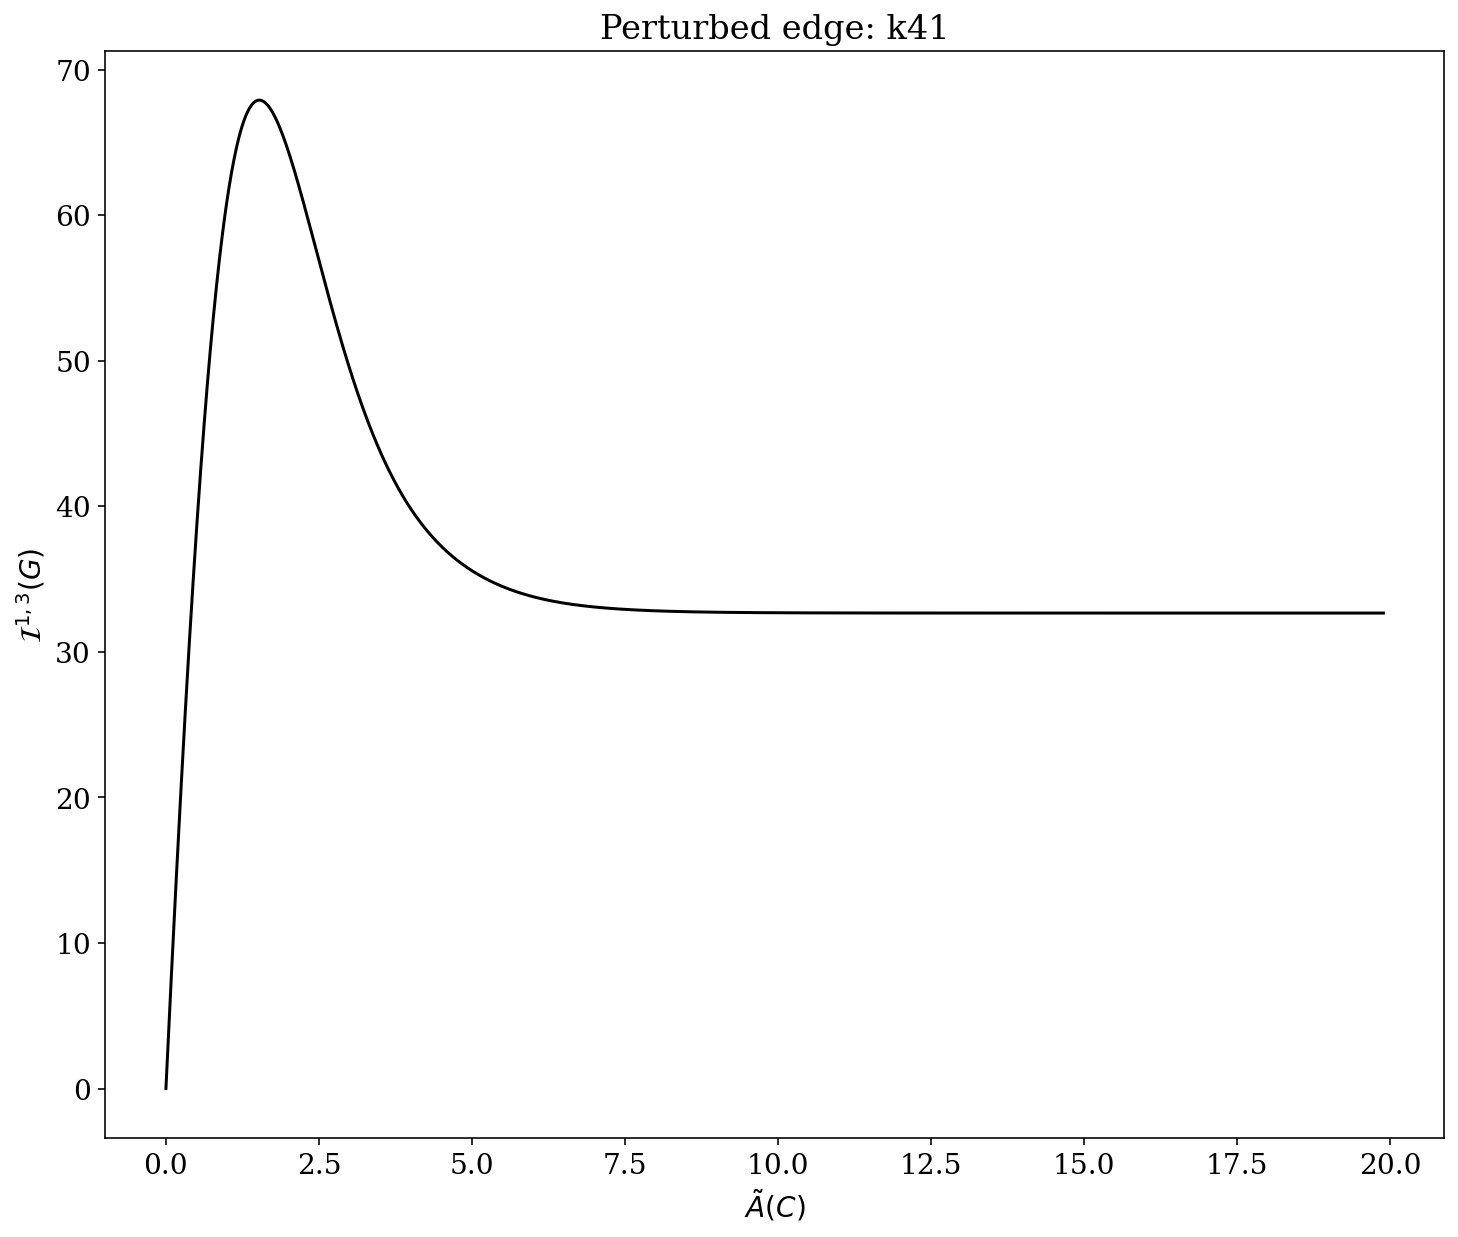

In [20]:
edge_map = {
    0: (1, 2),
    1: (2, 3),
    2: (3, 4),
    3: (4, 1)
}
src, tgt = edge_map[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}.png", dpi=300)
plt.show()

In [21]:
# k32
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
edge_idx = 1
perturb_edge = labels_r[edge_idx] # labels_r[1] = k32

for i in tqdm(range(0,N)):
    
    labels_r[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    pi = mtt_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    perturb_edge *= 1.01

np.savez(f"steinberg_edge_{edge_idx}_r.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [06:03<00:00,  5.50it/s]


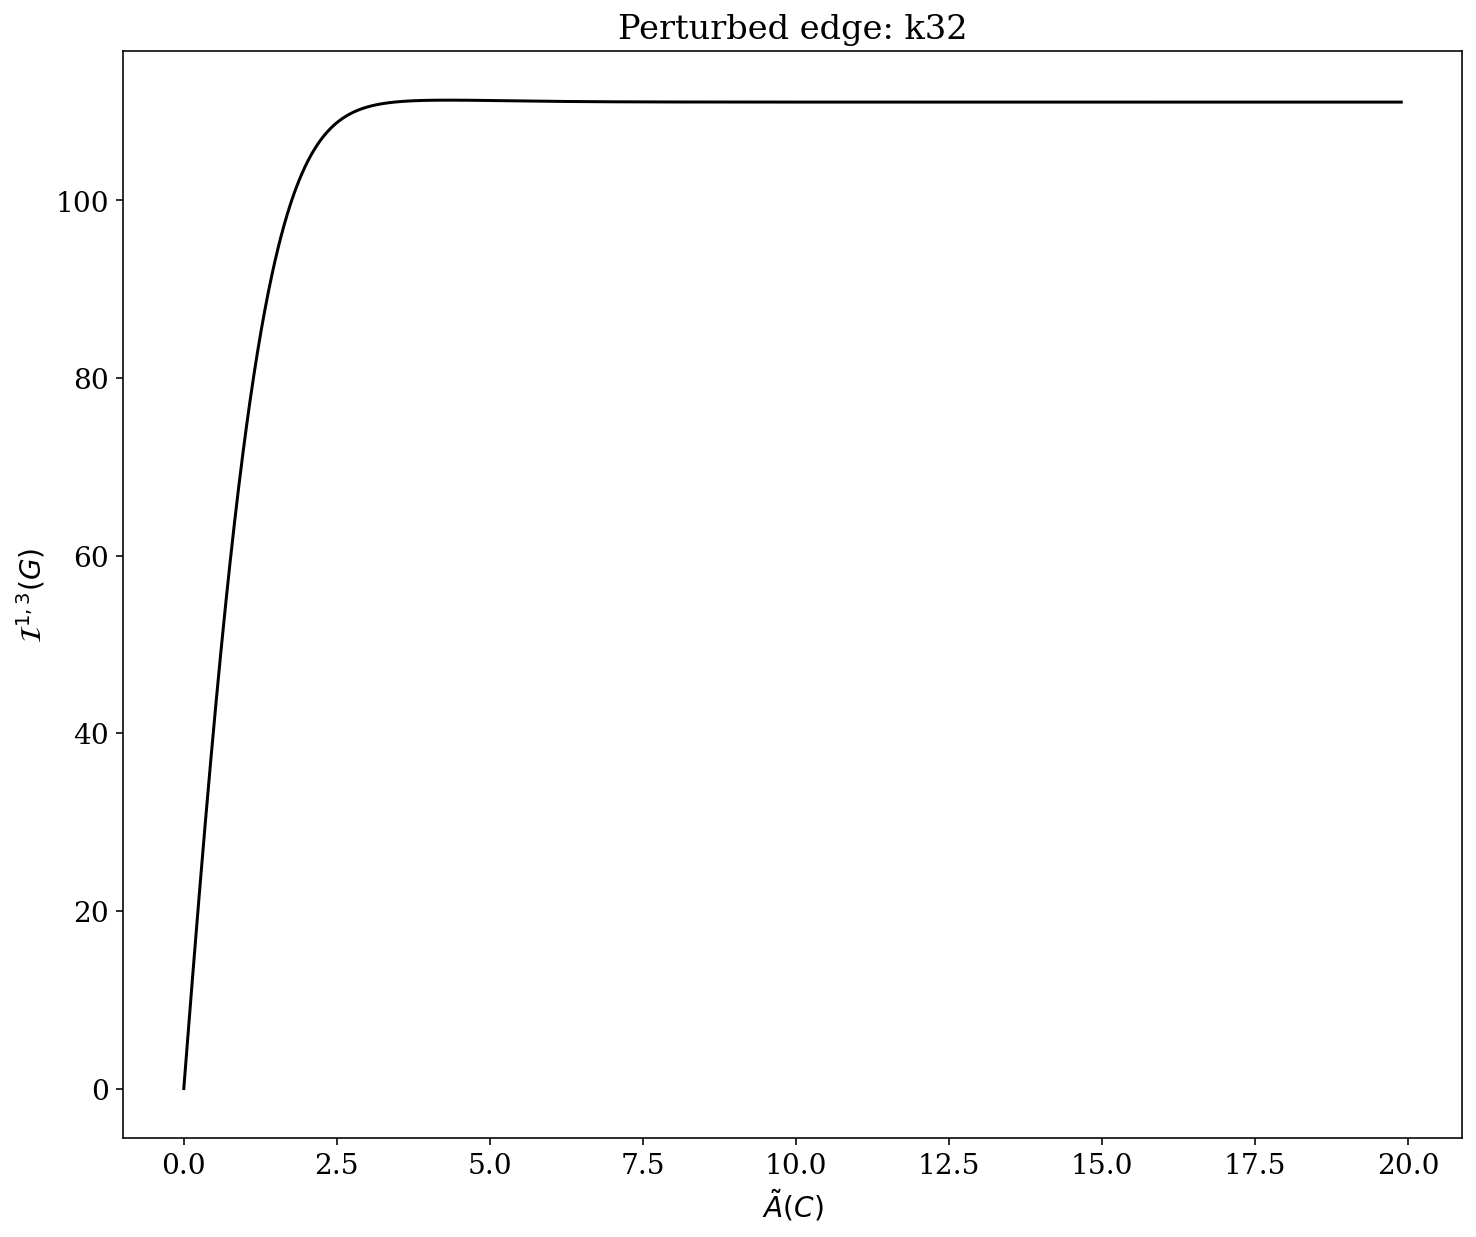

In [22]:
edge_map_rev = {
    0: (2, 1),
    1: (3, 2),
    2: (4, 3),
    3: (1, 4)
}

src, tgt = edge_map_rev[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}_r.png", dpi=300)
plt.show()

In [23]:
#k21
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
edge_idx = 0
perturb_edge = labels_r[edge_idx] # labels_r[0] = k21

for i in tqdm(range(0,N)):
    
    labels_r[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    pi = mtt_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    perturb_edge *= 1.01

np.savez(f"steinberg_edge_{edge_idx}_r.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [06:08<00:00,  5.42it/s]


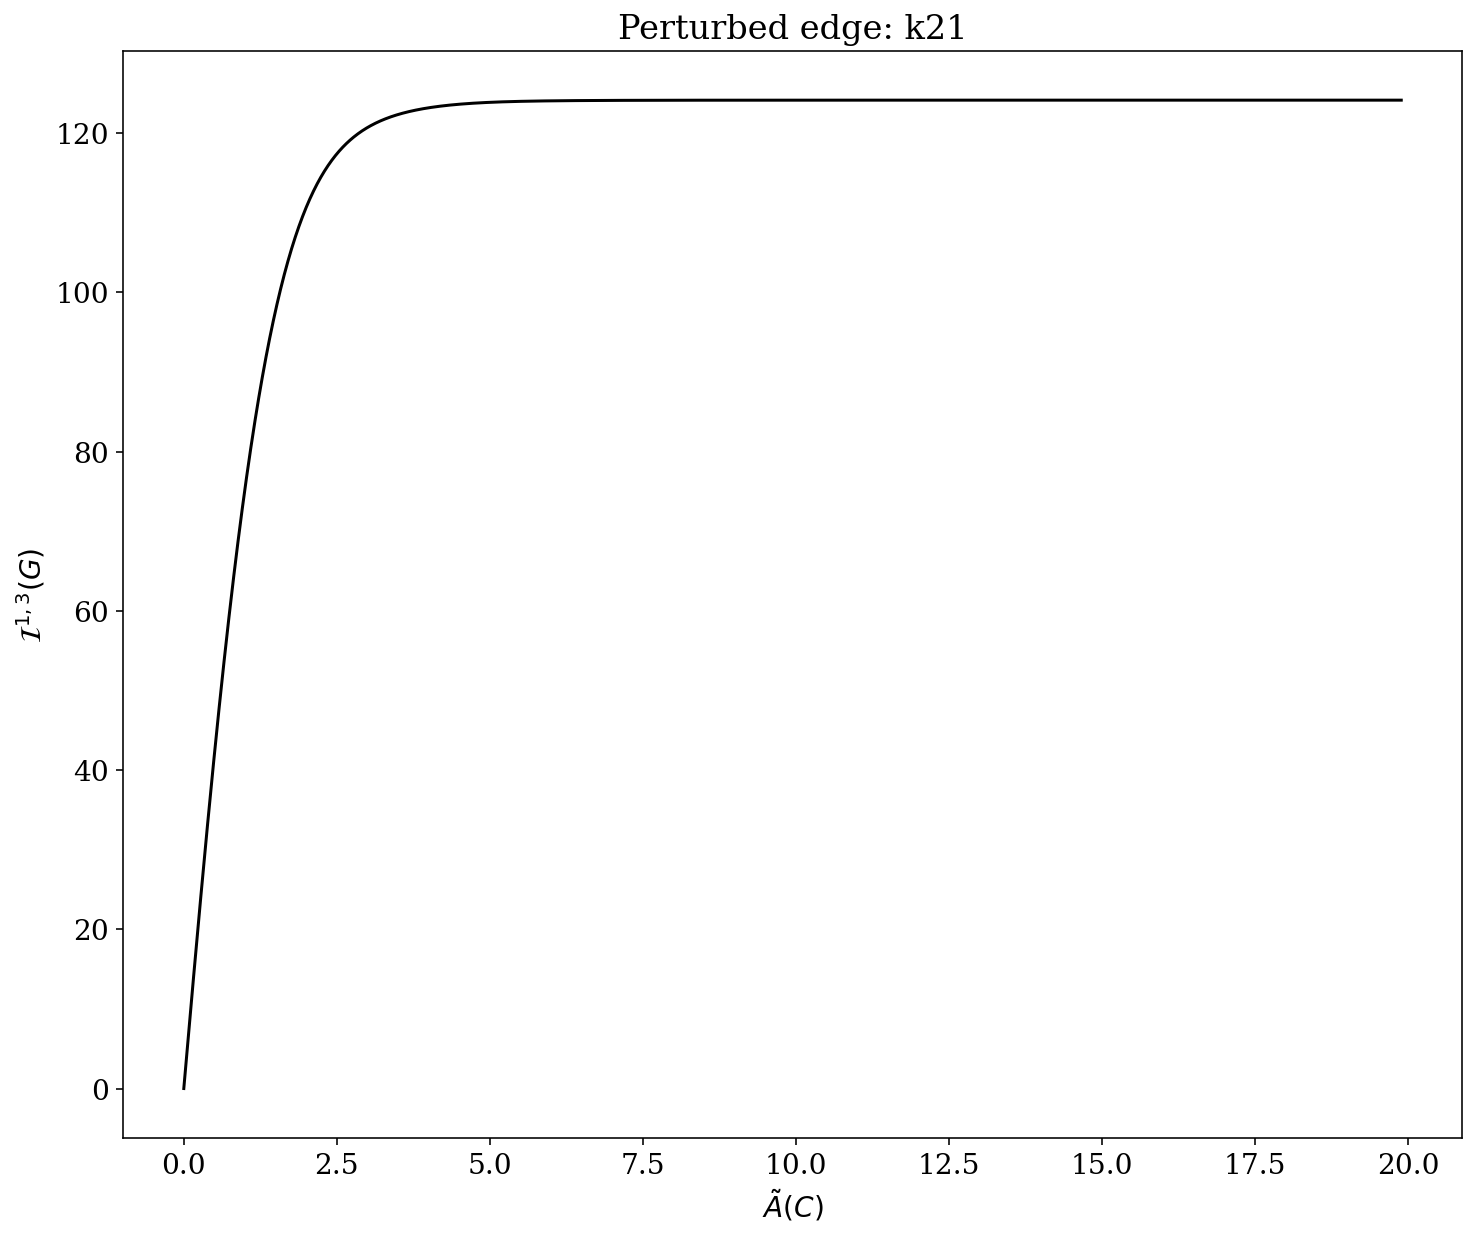

In [ ]:
edge_map_rev = {
    0: (2, 1),
    1: (3, 2),
    2: (4, 3),
    3: (1, 4)
}

src, tgt = edge_map_rev[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}_r.png", dpi=300)
plt.show()

In [25]:
#k43
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
edge_idx = 2
perturb_edge = labels_r[edge_idx] # labels_r[2] = k43

for i in tqdm(range(0,N)):
    
    labels_r[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    pi = mtt_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    perturb_edge *= 1.01
    
np.savez(f"steinberg_edge_{edge_idx}_r.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [06:09<00:00,  5.41it/s]


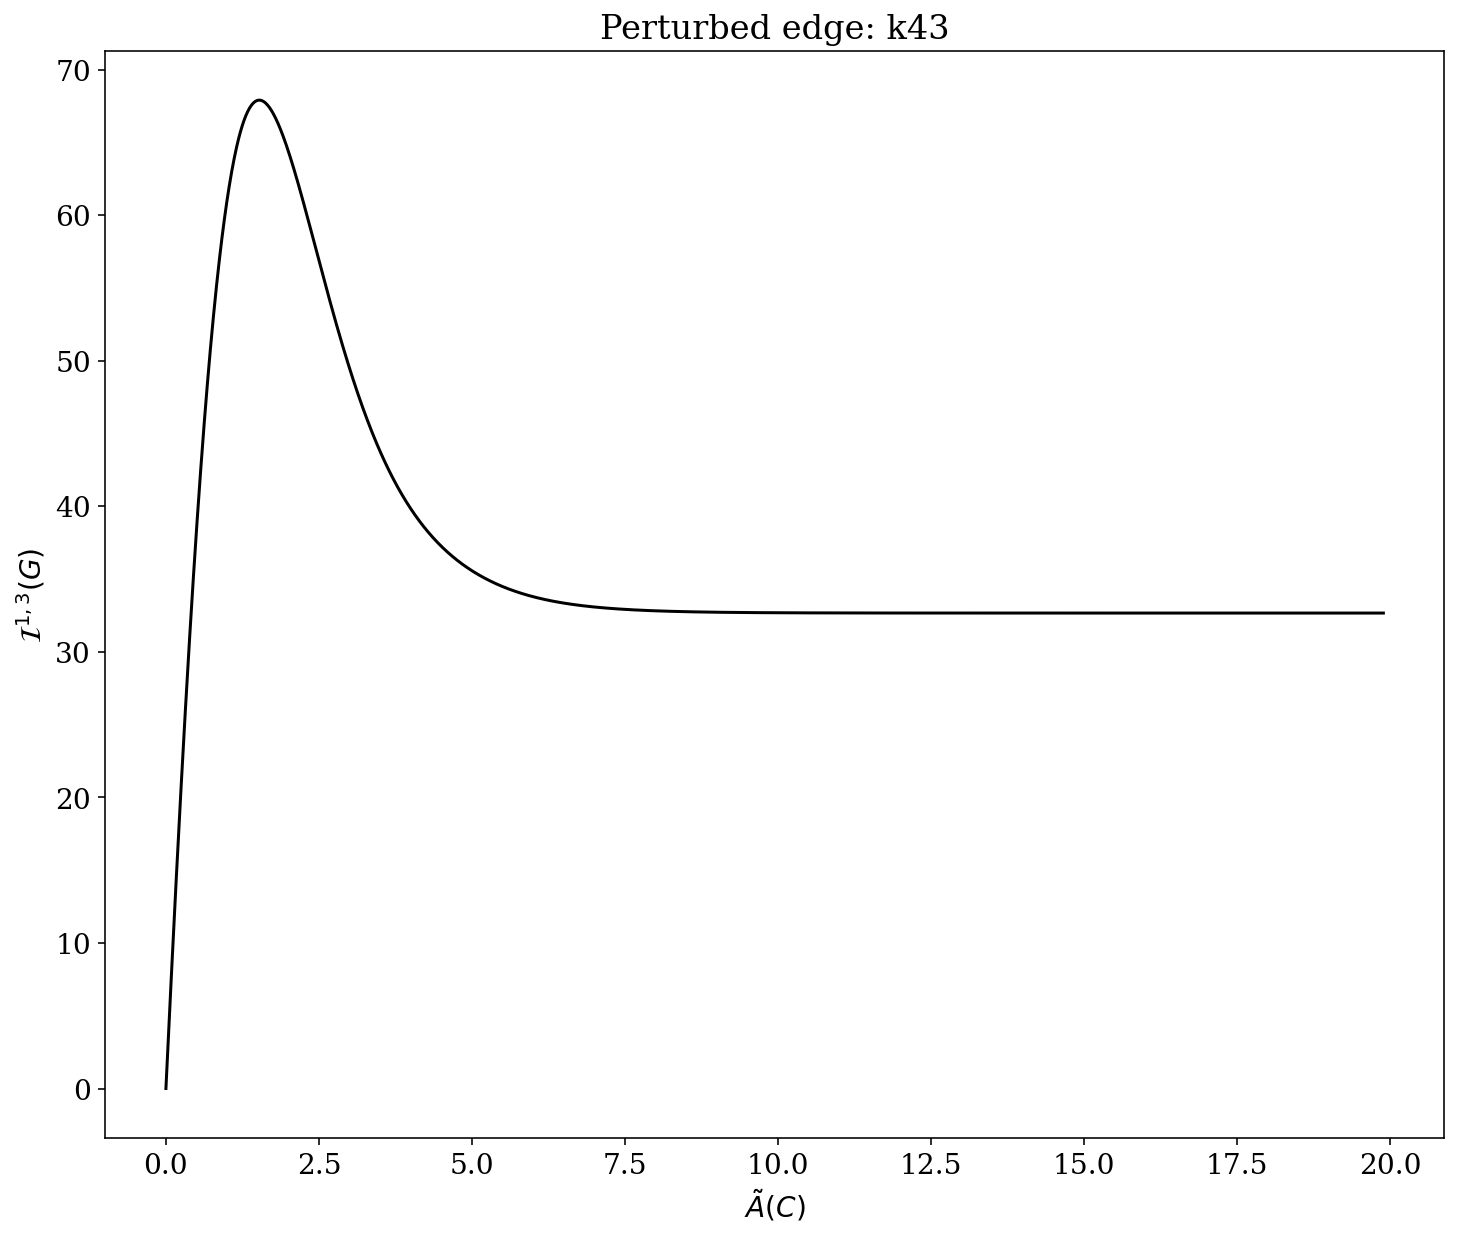

In [26]:
edge_map_rev = {
    0: (2, 1),
    1: (3, 2),
    2: (4, 3),
    3: (1, 4)
}

src, tgt = edge_map_rev[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}_r.png", dpi=300)
plt.show()

In [27]:
#k14
labels_f = [1.0, 1.0, 1.0, 1.0]
labels_r = [1.0, 1.0, 1.0, 1.0]

signal = [3,5,7,9]
alpha, beta  = 1, 3
tau = np.linspace(0.01, 200, num=1000)

N = 2000
affinities = np.empty(N, dtype=float)
areas = np.empty(N, dtype=float)
edge_idx = 3
perturb_edge = labels_r[edge_idx] # labels_r[3] = k14

for i in tqdm(range(0,N)):
    
    labels_r[edge_idx] = perturb_edge
    
    lap = lap_k4(labels_f, labels_r)
    pi = mtt_k4(labels_f, labels_r)
    
    aff = np.abs(np.log(np.prod(labels_f)/np.prod(labels_r)))
    affinities[i] = aff
    
    a13, a31 = autocorrelation_analytical(signal,lap,tau,alpha=1,beta=3)
    areas[i] = np.abs(np.trapz(a13)-np.trapz(a31))
    
    perturb_edge *= 1.01
    
np.savez(f"steinberg_edge_{edge_idx}_r.npz", affinities=affinities, areas=areas)

100%|███████████████████████████████████████| 2000/2000 [06:18<00:00,  5.29it/s]


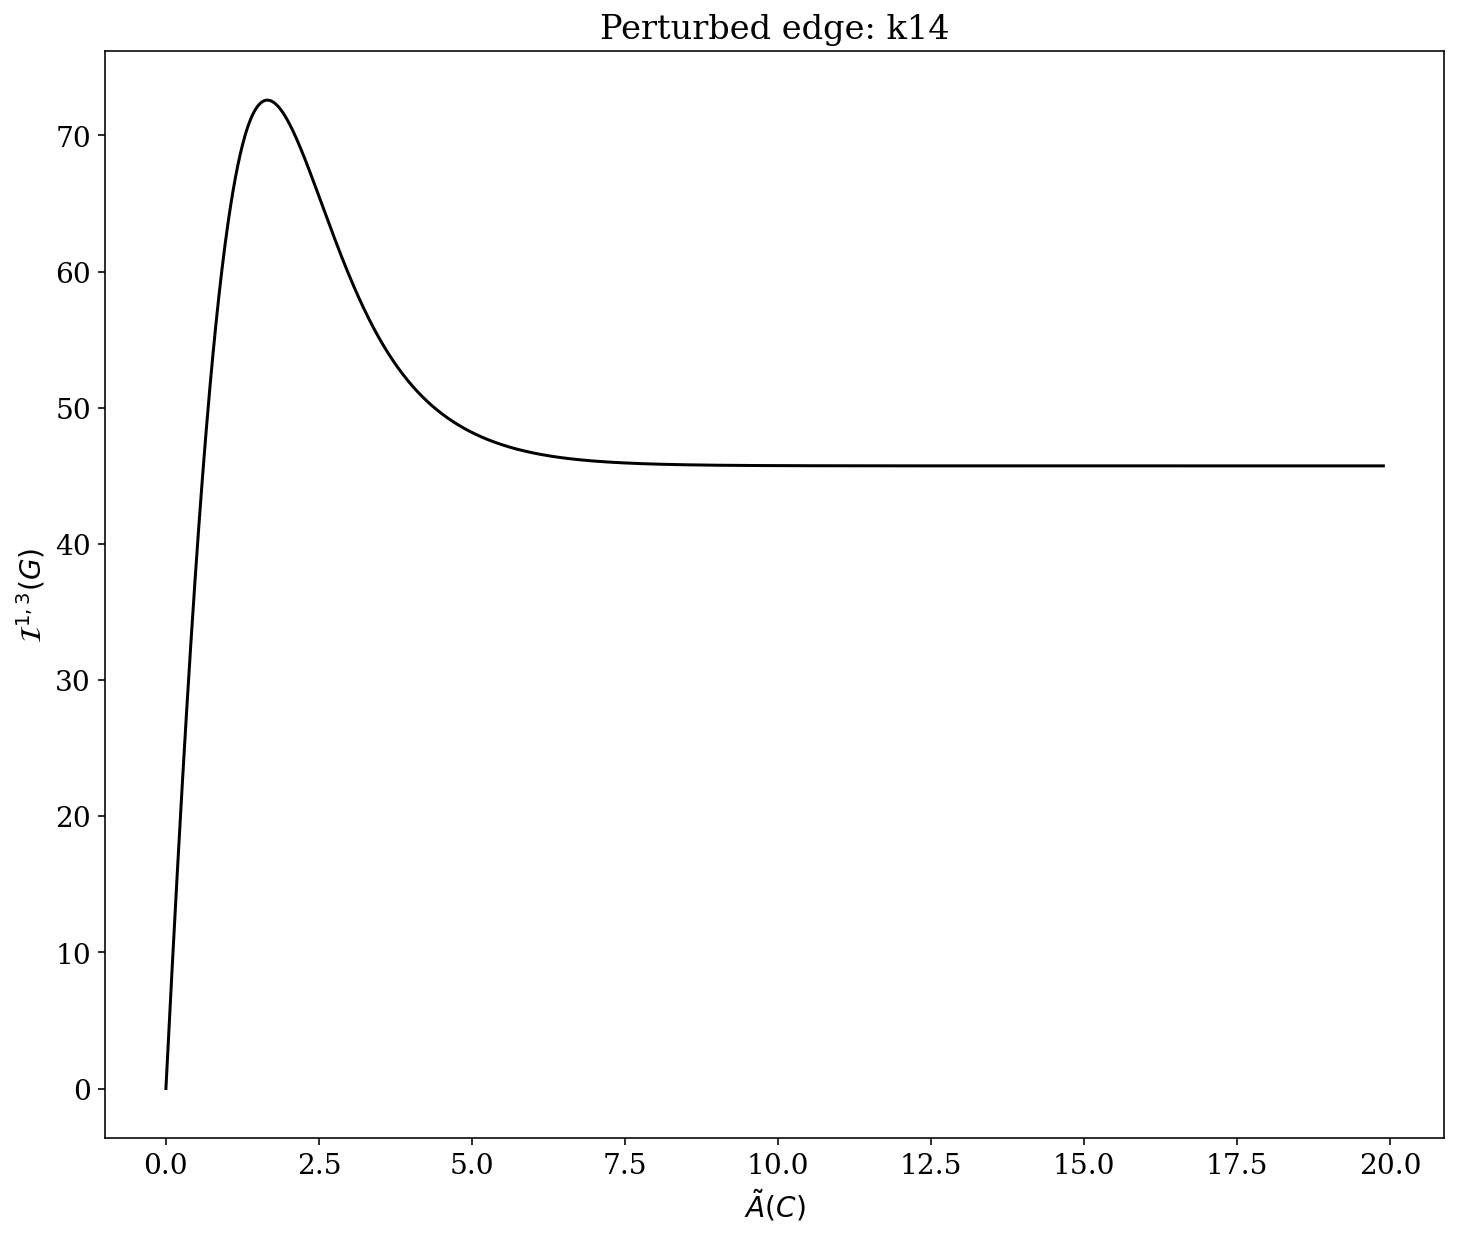

In [28]:
edge_map_rev = {
    0: (2, 1),
    1: (3, 2),
    2: (4, 3),
    3: (1, 4)
}

src, tgt = edge_map_rev[edge_idx]

plt.figure()
plt.plot(affinities, areas, color='black')
plt.xlabel(r"$\tilde{A}(C)$")
plt.ylabel(r"$\mathcal{I}^{1,3}(G)$")
plt.title(f"Perturbed edge: k{src}{tgt}")
plt.savefig(f"steinberg_curve_edge_{edge_idx}_r.png", dpi=300)
plt.show()